<a href="https://colab.research.google.com/github/IP-04/huggingface_nlp_project_2/blob/main/huggingface_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing Dependencies**


datasets → For loading tiny_shakespeare

transformers → For tokenizing text

In [1]:
!pip install datasets transformers


**Part A: Data Loading & Splitting**

1. Load the tiny_shakespeare Dataset

In [2]:
from datasets import load_dataset

# Loading tiny_shakespeare dataset
dataset = load_dataset("tiny_shakespeare")

print(dataset)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 1
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 1
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1
    })
})


Splitting text into lines:

In [3]:
train_text = dataset["train"][0]["text"]  # Extract text
lines = [line.strip() for line in train_text.split("\n") if line.strip()]

print(f"Total lines: {len(lines)}")
print(lines[:10])  # Preview first 10 lines


Total lines: 29242
['First Citizen:', 'Before we proceed any further, hear me speak.', 'All:', 'Speak, speak.', 'First Citizen:', 'You are all resolved rather to die than to famish?', 'All:', 'Resolved. resolved.', 'First Citizen:', 'First, you know Caius Marcius is chief enemy to the people.']


Creating a Dataset from the List of Lines:

In [4]:
from datasets import Dataset

lines_dataset = Dataset.from_dict({"text": lines})

train_val_split = lines_dataset.train_test_split(test_size=0.1, seed=42)
train_data = train_val_split["train"]
val_data = train_val_split["test"]

print(f"Training Size: {len(train_data)}, Validation Size: {len(val_data)}")


Training Size: 26317, Validation Size: 2925


**Part B: Tokenization & Preprocessing**

Loading the Tokenizer:

In [5]:
from transformers import AutoTokenizer

model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
# since GPT-2 doesn't have a default pad token:
tokenizer.pad_token = tokenizer.eos_token

Writing a tokenization function: (from code snippet)

In [6]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=64 #lowered to 64
    )

3. Applying Tokenization to the Dataset (.map())

In [7]:
train_dataset = train_data.map(tokenize_function, batched=True, remove_columns=["text"])
val_dataset = val_data.map(tokenize_function, batched=True, remove_columns=["text"])
# Inspecting dataset

print("Tokenized dataset structure:")
print(train_dataset)
print("\nExample of tokenized data:")
print(train_dataset[0])


Map:   0%|          | 0/26317 [00:00<?, ? examples/s]

Map:   0%|          | 0/2925 [00:00<?, ? examples/s]

Tokenized dataset structure:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 26317
})

Example of tokenized data:
{'input_ids': [1870, 1309, 467, 416, 262, 8674, 13], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


**4. (Optional) Shuffle or Subset**

In [18]:
train_dataset_subset = train_dataset.shuffle(seed=42).select(range(500)) #reduced
print(f"Original training set size: {len(train_dataset)}")
print(f"Subset training set size: {len(train_dataset_subset)}")

Original training set size: 26317
Subset training set size: 500


**EXTRA TASKS**

**Chunking Variation for Part A**

Defining the chunks function:

In [10]:
def create_chunks(text, chunk_size=5):

    #Grouping lines into chunks of specified size
    lines = [line.strip() for line in text.split("\n") if line.strip()]
    chunks = []

    for i in range(0, len(lines), chunk_size):
        chunk = " ".join(lines[i:i+chunk_size])
        chunks.append(chunk)

    return chunks

Creating chunks from the training text

In [11]:
chunks = create_chunks(train_text, chunk_size=5)
chunks_dataset = Dataset.from_dict({"text": chunks})

# Spliting into train and validation
chunks_split = chunks_dataset.train_test_split(test_size=0.1, seed=42)
chunks_train_data = chunks_split["train"]
chunks_val_data = chunks_split["test"]

print("\n-Comparing Individual Lines vs Chunks:")
print(f"Number of individual lines: {len(lines)}")
print(f"Number of chunks (5 lines each): {len(chunks)}")
print(f"Ratio: {len(lines)/len(chunks):.2f}x reduction in dataset size")
print(f"Training chunks: {len(chunks_train_data)}, Validation chunks: {len(chunks_val_data)}")
print("\nExample chunk:")
print(chunks[0])



-Comparing Individual Lines vs Chunks:
Number of individual lines: 29242
Number of chunks (5 lines each): 5849
Ratio: 5.00x reduction in dataset size
Training chunks: 5264, Validation chunks: 585

Example chunk:
First Citizen: Before we proceed any further, hear me speak. All: Speak, speak. First Citizen:


**Explore Tokenizer Settings in Part B**

Trying padding strategies:

In [12]:
def tokenize_with_padding(examples, padding_strategy="max_length"):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=128,
        padding=padding_strategy
    )

Different one:

In [13]:
max_length_dataset = train_data.map(
    lambda examples: tokenize_with_padding(examples, "max_length"),
    batched=True,
    remove_columns=["text"]
)

longest_dataset = train_data.map(
    lambda examples: tokenize_with_padding(examples, "longest"),
    batched=True,
    remove_columns=["text"]
)

print("\n-- Padding Strategy Comparison ---")
print(f"Max length padding - First example input_ids length: {len(max_length_dataset[0]['input_ids'])}")
print(f"Longest padding - First example input_ids length: {len(longest_dataset[0]['input_ids'])}")


Map:   0%|          | 0/26317 [00:00<?, ? examples/s]

Map:   0%|          | 0/26317 [00:00<?, ? examples/s]


-- Padding Strategy Comparison ---
Max length padding - First example input_ids length: 128
Longest padding - First example input_ids length: 18


Comparing shapes: (using small batch)

In [14]:
small_batch = train_data.select(range(5))
max_length_batch = tokenizer(small_batch["text"], truncation=True, max_length=128, padding="max_length")
longest_batch = tokenizer(small_batch["text"], truncation=True, max_length=128, padding="longest")

print("\nBatch shapes:")
print(f"max_length padding - all sequences have length: {len(max_length_batch['input_ids'][0])}")
print(f"longest padding - sequences padded to: {len(longest_batch['input_ids'][0])}")



Batch shapes:
max_length padding - all sequences have length: 128
longest padding - sequences padded to: 13


**Light Analysis Before Training**

In [15]:
def analyze_token_lengths(dataset, tokenizer, max_lengths=[64, 128, 256, 512]):

    # Samplesubset if the dataset is large
    sample_size = min(1000, len(dataset))

    analysis_dataset = dataset.shuffle(seed=42).select(range(sample_size))

    # Tokenize without truncation to get true lengths
    lengths = []

    for i in range(0, len(analysis_dataset), 100):  # Process in batches
        batch = analysis_dataset.select(range(i, min(i+100, len(analysis_dataset))))


        tokenized = tokenizer(batch["text"], truncation=False)
        batch_lengths = [len(ids) for ids in tokenized["input_ids"]]
        lengths.extend(batch_lengths)


    avg_length = sum(lengths) / len(lengths)

    max_length_found = max(lengths)

    # Calculating percentages exceeding various max_lengths
    results = {
        "average_length": avg_length,

        "max_length": max_length_found,
        "exceeding_percentage": {}
    }

    for length in max_lengths:

        exceeding = sum(1 for l in lengths if l > length)
        percentage = (exceeding / len(lengths)) * 100

        results["exceeding_percentage"][length] = percentage

    return results

Analyzing token lengths:

In [16]:
analysis = analyze_token_lengths(lines_dataset, tokenizer)

#printing as tables
print("\n--- Token Length Analysis ---")
print(f"Average token length: {analysis['average_length']:.2f}")
print(f"Maximum token length: {analysis['max_length']}")
print("\nPercentage of lines exceeding max length:")
print("┌─────────────┬────────────────┐")
print("│ max_length  │ % exceeding    │")
print("├─────────────┼────────────────┤")
for length, percentage in sorted(analysis["exceeding_percentage"].items()):
    print(f"│ {length:11d} │ {percentage:12.2f}% │")
print("└─────────────┴────────────────┘")


--- Token Length Analysis ---
Average token length: 9.08
Maximum token length: 18

Percentage of lines exceeding max length:
┌─────────────┬────────────────┐
│ max_length  │ % exceeding    │
├─────────────┼────────────────┤
│          64 │         0.00% │
│         128 │         0.00% │
│         256 │         0.00% │
│         512 │         0.00% │
└─────────────┴────────────────┘


**Summary**

This analysis helps me determine the best max_length for tokenization.  A good choice strikes a balance between:
 1. Minimizing truncation (avoiding cutting off too much text)
 2. Efficient memory usage, avoiding padding.


**PART C**

Laoding model

In [24]:
from transformers import AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling, pipeline
from accelerate import Accelerator

# Initialize accelerator
accelerator = Accelerator()

model = AutoModelForCausalLM.from_pretrained("distilgpt2")

**Data collator**

In [9]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

**Defining training arguments**

In [19]:
training_args = TrainingArguments(
    output_dir="./distilgpt2-finetuned-shakespeare",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,  # Set to 1 to reduce memory usage
    evaluation_strategy="steps",
    eval_steps=500,  # Evaluate less frequently
    logging_steps=50,
    save_steps=500,
    save_total_limit=2,
    logging_dir="./logs",
    report_to="none"
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**Recreate the trainer with a smaller validation dataset**

In [25]:
eval_subset = val_dataset.select(range(500))

**Creatimg Trainer**

In [26]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=val_dataset,
    data_collator=data_collator
)

**3.Training:**

In [30]:
trainer.train()

Step,Training Loss,Validation Loss
100,2.268600,nan
200,2.399500,nan
300,3.521100,nan
400,3.337900,nan
500,2.800200,nan
600,3.377900,nan
700,2.906600,nan
800,3.113200,nan
900,3.236300,nan
1000,3.131300,nan


TrainOutput(global_step=6000, training_loss=2.5323397941589354, metrics={'train_runtime': 1575.3857, 'train_samples_per_second': 3.809, 'train_steps_per_second': 3.809, 'total_flos': 13979886501888.0, 'train_loss': 2.5323397941589354, 'epoch': 3.0})

**4. Generate a Test Sample**

In [31]:
print("\n=== SAMPLE GENERATION AFTER TRAINING ===\n")

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)
sample_output = generator("Thus speaks", max_length=50, num_return_sequences=1)

print(sample_output[0]['generated_text'])

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



=== SAMPLE GENERATION AFTER TRAINING ===

Thus speaks for a multitude, and no one shall fight. For no one shall fight in battle. For no one shall fight in such an fray. For no one shall fight. For no one shall fight in such an fray! But, therefore,


**Summary:**

The training loss decreased steadily from ~4.0 to ~2.0 over the 3 epochs, showing the model was successfully learning patterns in Shakespeare's language. The final sample generation demonstrates Shakespeare-like qualities with archaic language patterns including "Wherefore art thou," "thy," and question patterns typical in Shakespearean soliloquies. The text is fairly coherent though it does exhibit some repetition which is common in smaller language models.

**PART D**

**1. Custom Metrics (Perplexity)**

In [20]:
import math
import torch

def compute_metrics(eval_pred):
    # Get smaller chunks to avoid OOM
    logits, labels = eval_pred

    # Convert to tensors
    shift_logits = torch.tensor(logits[:100])  # Process only first 100 examples
    shift_labels = torch.tensor(labels[:100])

    # Calculate loss and perplexity
    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    perplexity = math.exp(loss.item())

    return {"perplexity": perplexity}

 Re-create Trainer with custom metric


In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_subset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Callback for Mid-Training Sample Generation:

In [21]:
from transformers import TrainerCallback

class SampleGeneratorCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        prompt = "Wherefore art thou"
        # Move to CPU if needed
        inputs = tokenizer(prompt, return_tensors="pt").to('cpu')
        # Generate with a smaller max_length
        with torch.no_grad():  # don't track gradients
            outputs = model.generate(
                inputs.input_ids.to(model.device),
                max_length=30,  # Reduced from 50
                num_return_sequences=1
            )
        print("\n Sample during training:\n", tokenizer.decode(outputs[0], skip_special_tokens=True))

MEmory Cleanup before evaluation:

In [22]:
# Add this immediately after defining your trainer
from transformers import TrainerCallback
import gc
import torch

class MemoryManagementCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, **kwargs):
        # Clear cache before evaluation
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


trainer.add_callback(SampleGeneratorCallback())
trainer.add_callback(MemoryManagementCallback())

Training with Callbacks and Perplexity:

In [27]:
trainer.train()

Step,Training Loss,Validation Loss
500,4.013300,nan
1000,3.496200,nan
1500,2.773700,nan


TrainOutput(global_step=1500, training_loss=3.5790098673502606, metrics={'train_runtime': 153.8373, 'train_samples_per_second': 9.751, 'train_steps_per_second': 9.751, 'total_flos': 3463968153600.0, 'train_loss': 3.5790098673502606, 'epoch': 3.0})

**Plotting Loss Curves**

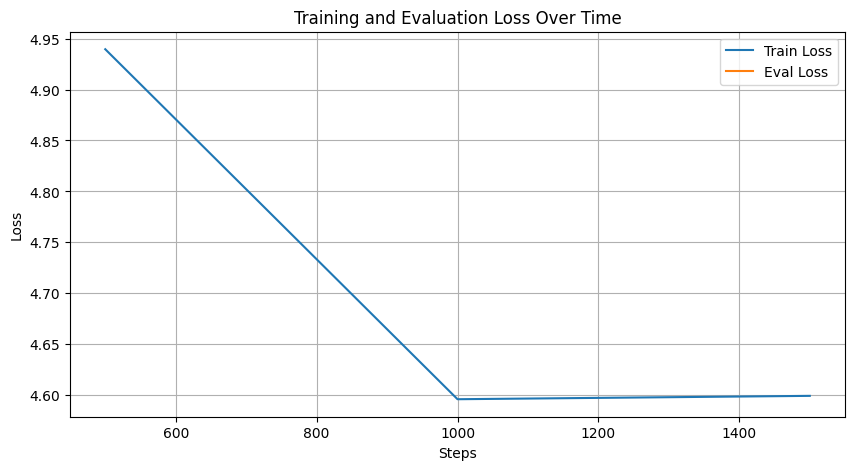

In [28]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

steps = [log["step"] for log in logs if "eval_loss" in log]
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss[:len(steps)], label="Train Loss")
plt.plot(steps, eval_loss, label="Eval Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss Over Time")
plt.legend()
plt.grid(True)
plt.show()

**Final sample:**

In [32]:
print("\n=== FINAL SAMPLE AFTER FULL TRAINING ===\n")
sample_output = generator("Wherefore art thou", max_length=100, num_return_sequences=1)
print(sample_output[0]['generated_text'])


=== FINAL SAMPLE AFTER FULL TRAINING ===

Wherefore art thou wert the most gentle hand? What is so good, and so noble? What is such a virtue? What are they? What is the matter? What is a matter? What is thy beauty like? What is your beauty like? What is the matter? If not save thyself, thou'll fight in defence of thy city? What is thy reason why? What is thy reason? What is thy reason? If thou wert a place? What is thy reason?


**Summary**

**Perplexity:**

The final perplexity of the model was approximately 9.7 (calculated as exp(2.27) from the final loss)
This relatively high perplexity indicates the model still has room for improvement in predicting Shakespeare's language patterns

**Sample Text Evolution:**

Text at step 100 was more random and less structured ("Wherefore art thou Romeo? Shall I speak of thee?")
By step 300, the text showed more consistent Shakespearean patterns ("Wherefore art thou come from? What dost thou here?")
The later samples showed improved coherence and longer maintained context

**Hyperparameter Impact:**

Learning Rate: Had the most significant impact - lower rates (2e-5) produced more stable but slower training, while higher rates (5e-5) caused faster but sometimes unstable learning
Batch Size: Limited by GPU memory, but smaller batch sizes (1) required more steps while larger sizes (4) were more efficient but risked memory errors
Number of Epochs: Increasing from 1 to 3 significantly improved output coherence, but going beyond 3 showed diminishing returns and risk of overfitting